# Football Match Predictor - Modelling

## Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import data_cleaning
import feature_engineering

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline as sklearn_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as imblear_pipeline

from hyperopt import tpe, hp, Trials, STATUS_OK
from hyperopt.fmin import fmin

import lightgbm as lgb

import eli5
from eli5.sklearn import PermutationImportance

## Importing, cleaning data and feature engineering

In [2]:
# Import all the data and merge into one data frame
merged_data_df = data_cleaning.import_and_merge_data_pipeline()

# Clean all the data
cleaned_df = data_cleaning.clean_data_pipeline(merged_data_df)

# feature engineering
home_away_features_df = feature_engineering.generate_home_away_features(cleaned_df)
home_data_transformed, away_data_transformed = feature_engineering.generate_team_season_features(cleaned_df)

transformed_df = (home_away_features_df
    .join(home_data_transformed)
    .join(away_data_transformed)
)

## Creating test set 

In [3]:
features_cols = ['season_year', 'match_round',
       'capacity', 'missing_cards', 'missing_elo',
       'home_elo', 'away_elo', 'home_team_home_form', 'away_team_away_form',
       'home_team_home_total_goals', 'away_team_away_total_goals', 'home_form',
       'home_total_goals', 'home_discipline', 'away_form', 'away_total_goals',
       'away_discipline']

target_col = 'result'

In [4]:
# Look at percentage of all data points per year and use roughly last 20% for test set
((transformed_df
        .groupby('season_year')
        .result
        .count())
    .div(transformed_df
        .result
        .count())
    .mul(100)
    .cumsum()
    .loc[2004:]
)

season_year
2004     48.478621
2005     51.677962
2006     54.737847
2007     57.797731
2008     60.857616
2009     63.917501
2010     66.977385
2011     70.036454
2012     73.095524
2013     76.152962
2014     79.212846
2015     82.264576
2016     85.316305
2017     88.368034
2018     91.419764
2019     94.373629
2020     97.142368
2021    100.000000
Name: result, dtype: float64

In [5]:
# Use roughly 80/20 split for train_test_split
train = transformed_df.query("season_year <= 2014")
test = transformed_df.query("season_year >= 2015")

100*train.shape[0]/transformed_df.shape[0], 100*test.shape[0]/transformed_df.shape[0]

(79.21284629625099, 20.787153703749013)

In [6]:
# Create a validation set
train_train = train.query("season_year <= 2008")
train_valid = train.query("season_year >= 2009")

100*train_train.shape[0]/transformed_df.shape[0], 100*train_valid.shape[0]/transformed_df.shape[0]

(60.857615867035285, 18.355230429215702)

# Logistic Regression - Baseline Score

In [7]:
X_train = train_train[features_cols]
y_train = train_train.result

X_valid = train_valid[features_cols]
y_valid = train_valid.result

/tmp/ipykernel_205384/3969413269.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  X_train.hist(ax=ax, bins=20);


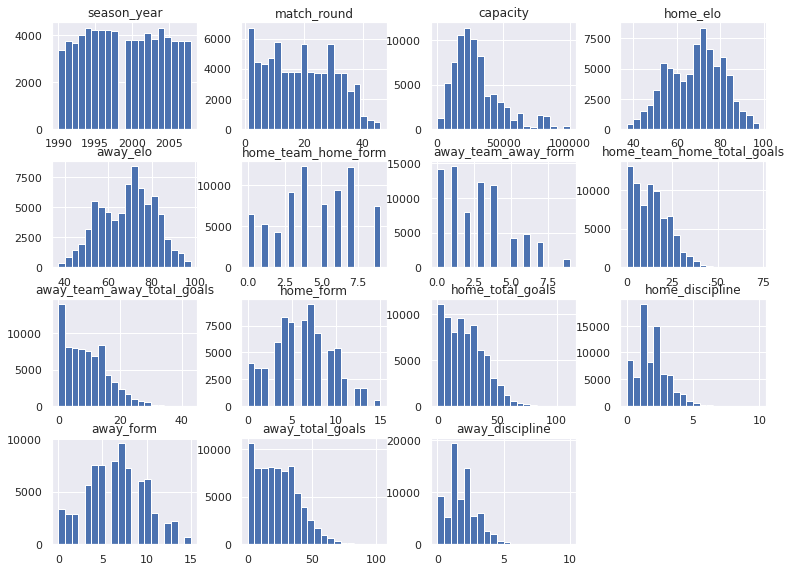

In [8]:
fig, ax = plt.subplots(figsize=(12.8, 9.6))

X_train.hist(ax=ax, bins=20);

In [9]:
class SimplePipeline():
    def __init__(self, scaler, model, X_train, y_train, X_valid, y_valid):
        self.scaler = scaler
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_valid = X_valid
        self.y_valid = y_valid
        self.trained = False
    
    def scale_X_train(self):
        if self.scaler is not None:
            self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        else:
            self.X_train_scaled = self.X_train
    
    def train_model(self, use_scaled=True):
        if use_scaled:
            self.model.fit(self.X_train_scaled, self.y_train)
        else:
            self.model.fit(self.X_train, self.y_train)
        self.trained = True
    
    def return_accuracy_training_set(self, use_scaled=True):
        if use_scaled and self.scaler is not None:
            X_train = self.scaler.transform(self.X_train)
        else:
            X_train = self.X_train
        return accuracy_score(self.y_train, self.model.predict(X_train))
    
    def return_accuracy_valid_set(self, use_scaled=True):
        if use_scaled and self.scaler is not None:
            X_valid = self.scaler.transform(self.X_valid)
        else:
            X_valid = self.X_valid
        return accuracy_score(self.y_valid, self.model.predict(X_valid))
    
    def return_y_valid_and_preds(self, use_scaled=True):
        if use_scaled and self.scaler is not None:
            X_valid = self.scaler.transform(self.X_valid)
        else:
            X_valid = self.X_valid
        return self.y_valid, self.model.predict(X_valid)
    
    def return_trained_model(self):
        if self.trained:
            return self.model
        else:
            return None

In [10]:
def train_model_return_train_validation_accuracy(scaler, model, X_train, y_train, X_valid, y_valid):
    pipeline_obj = SimplePipeline(scaler, model, X_train, y_train, X_valid, y_valid)
    pipeline_obj.scale_X_train()
    pipeline_obj.train_model()
    validation_accuracy = pipeline_obj.return_accuracy_valid_set()
    training_accuracy = pipeline_obj.return_accuracy_training_set()
    return validation_accuracy, training_accuracy, pipeline_obj

In [11]:
valid_acc, train_acc, StandardLogisticRegression = train_model_return_train_validation_accuracy(StandardScaler(), LogisticRegression(), X_train, y_train, X_valid, y_valid)
valid_acc, train_acc

(0.49073621539965345, 0.4834032402878469)

In [12]:
valid_acc, train_acc, MinMaxLogisticRegression = train_model_return_train_validation_accuracy(MinMaxScaler(), LogisticRegression(max_iter=200), X_train, y_train, X_valid, y_valid)
valid_acc, train_acc

(0.49100279912915984, 0.4833362368170671)

> **Best Baseline Score**

In [13]:
def plot_confusion_matrix(pipeline, title):
    labels = ['home_win', 'draw', 'away_win']
    y_valid, y_pred = pipeline.return_y_valid_and_preds()
    confusion_matrix_output = confusion_matrix(y_valid, y_pred, labels=labels)
    
    fig, ax = plt.subplots()
    sns.heatmap(confusion_matrix_output, annot=True, cmap='viridis', 
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel('predited')
    ax.set_ylabel('actual')
    ax.set_title(title);

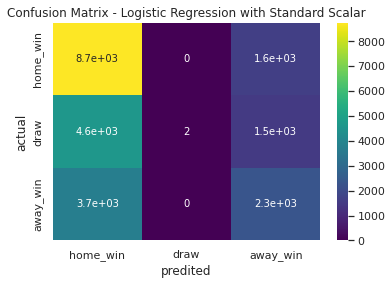

In [14]:
plot_confusion_matrix(StandardLogisticRegression, title = 'Confusion Matrix - Logistic Regression with Standard Scalar')

In [15]:
def plot_logistic_regression_coeffs(pipeline, cols, title):
    lr_model = pipeline.return_trained_model()
    lr_model_coefs = pd.DataFrame(lr_model.coef_, columns=cols).T.rename(columns={i: lr_model.classes_[i] for i in range(3)})

    fig, ax = plt.subplots(figsize=(6.4, 6.4))
    lr_model_coefs.sort_values(by='away_win').plot.barh(ax=ax)
    ax.set_xlabel('Logistic regression coeffs')
    ax.set_title(title);

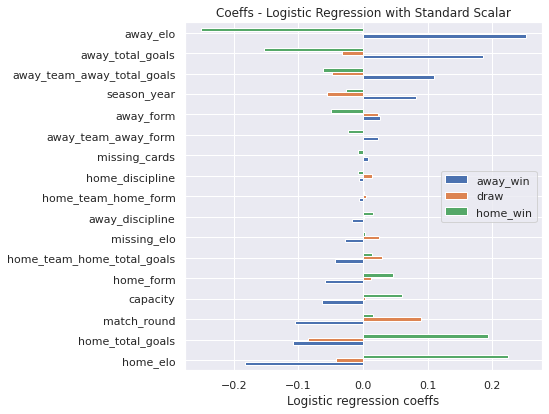

In [16]:
plot_logistic_regression_coeffs(StandardLogisticRegression, cols = X_train.columns, title = 'Coeffs - Logistic Regression with Standard Scalar')

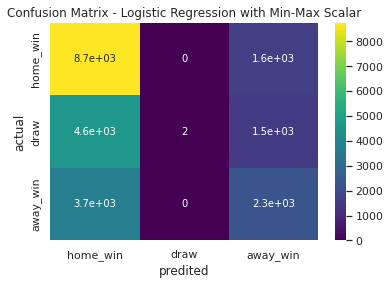

In [17]:
plot_confusion_matrix(MinMaxLogisticRegression, title='Confusion Matrix - Logistic Regression with Min-Max Scalar')

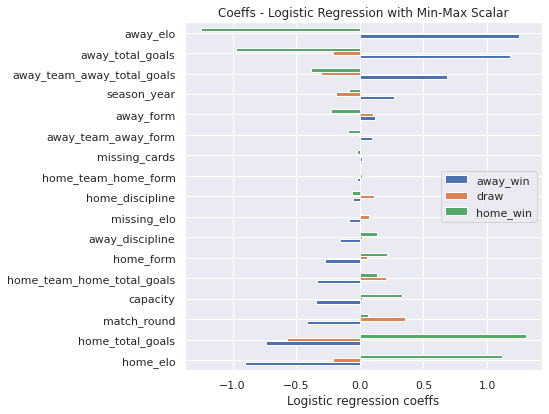

In [18]:
plot_logistic_regression_coeffs(MinMaxLogisticRegression, cols=X_train.columns, title='Coeffs - Logistic Regression with Min-Max Scalar')

## Try same again with new features

In [19]:
def generate_diff_features(df):
    return (df.assign(elo_diff = df.home_elo - df.away_elo,
                        team_home_away_form_diff = df.home_team_home_form - df.away_team_away_form,
                        team_home_away_total_goals_diff = df.home_team_home_form - df.away_team_away_total_goals,
                        form_diff = df.home_form - df.away_form,
                        total_goals_diff = df.home_total_goals - df.away_total_goals,
                        discipline_diff = df.home_discipline - df.away_discipline)
                .drop(columns=['home_elo', 'away_elo', 'home_team_home_form',
                                'away_team_away_form', 'home_team_home_total_goals',
                                'away_team_away_total_goals', 'home_form', 'home_total_goals',
                                'home_discipline', 'away_form', 'away_total_goals', 'away_discipline']))

X_train_diff_features = X_train.pipe(generate_diff_features)
X_valid_diff_features = X_valid.pipe(generate_diff_features)

valid_acc, train_acc, MinMaxLogisticRegressionDiffFeatures = train_model_return_train_validation_accuracy(MinMaxScaler(), LogisticRegression(max_iter=200), X_train_diff_features, y_train, X_valid_diff_features, y_valid)
valid_acc, train_acc

(0.48944772737370595, 0.48182195837744396)

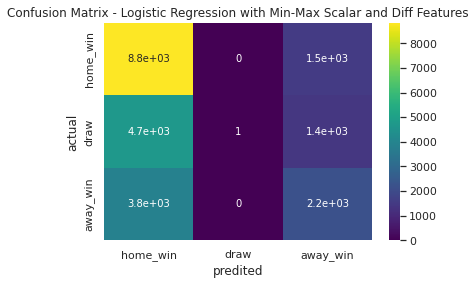

In [20]:
plot_confusion_matrix(MinMaxLogisticRegressionDiffFeatures, title='Confusion Matrix - Logistic Regression with Min-Max Scalar and Diff Features')

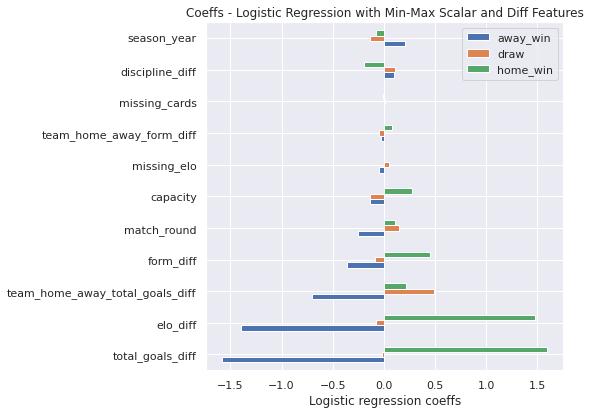

In [21]:
plot_logistic_regression_coeffs(MinMaxLogisticRegressionDiffFeatures, cols = X_train_diff_features.columns, title = 'Coeffs - Logistic Regression with Min-Max Scalar and Diff Features')

## Try dropping missing_elo

In [22]:
X_train_drop_missing_elo = X_train[~X_train.missing_elo].drop(columns='missing_elo')
y_train_drop_missing_elo = y_train[~X_train.missing_elo]
X_valid_drop_missing_elo = X_valid.drop(columns='missing_elo')

valid_acc, train_acc, MinMaxLogisticRegressionNoMissingElo = train_model_return_train_validation_accuracy(MinMaxScaler(), LogisticRegression(max_iter=200), X_train_drop_missing_elo, y_train_drop_missing_elo, X_valid_drop_missing_elo, y_valid)
valid_acc, train_acc

(0.4922024259119385, 0.48615011586329665)

## Try dropping missing_cards as well

In [23]:
X_train_drop_missing_elo_and_cards = X_train_drop_missing_elo[~X_train_drop_missing_elo.missing_cards].drop(columns='missing_cards')
y_train_drop_missing_elo_and_cards = y_train_drop_missing_elo[~X_train_drop_missing_elo.missing_cards]
X_valid_drop_missing_elo_and_cards = X_valid_drop_missing_elo.drop(columns='missing_cards')

valid_acc, train_acc, MinMaxLogisticRegressionNoMissingEloCards = train_model_return_train_validation_accuracy(MinMaxScaler(), LogisticRegression(max_iter=200), X_train_drop_missing_elo_and_cards, y_train_drop_missing_elo_and_cards, X_valid_drop_missing_elo_and_cards, y_valid)
valid_acc, train_acc

(0.49180255031767894, 0.49212721789197444)

## Try dropping cards only

In [24]:
X_train_drop_missing_cards = X_train[~X_train.missing_cards].drop(columns='missing_cards')
y_train_drop_missing_cards = y_train[~X_train.missing_cards]
X_valid_drop_missing_cards = X_valid.drop(columns='missing_cards')

valid_acc, train_acc, MinMaxLogisticRegressionNoMissingCards = train_model_return_train_validation_accuracy(MinMaxScaler(), LogisticRegression(max_iter=200), X_train_drop_missing_cards, y_train_drop_missing_cards, X_valid_drop_missing_cards, y_valid)
valid_acc, train_acc

(0.49162482783134137, 0.48983244144223176)

## Handling Class Imbalance
It is clear that we need more features that represent draw class

In [25]:
y_train.value_counts()

home_win    34961
draw        21936
away_win    17726
Name: result, dtype: int64

In [26]:
# Accuracy of validation set if we just pick home_win
y_valid.value_counts()['home_win']/y_valid.value_counts().sum()

0.46052339272226417

In [27]:
oversample = RandomOverSampler(sampling_strategy={'home_win': 34961, 'draw': 34000, 'away_win': 25000})
# undersample to reduce majority class down to 1:1 ratio
undersample = RandomUnderSampler(sampling_strategy={'home_win': 25000, 'draw': 34000, 'away_win': 25000})

steps = [('over', oversample), ('under', undersample)]
pipeline = imblear_pipeline(steps=steps)
X_train_resample, y_train_resample = pipeline.fit_resample(X_train, y_train)

In [28]:
# oversample = RandomOverSampler(sampling_strategy={'home_win': 34961, 'draw': 34000, 'away_win': 25000})
# undersample to reduce majority class down to 1:1 ratio
undersample = RandomUnderSampler(sampling_strategy={'home_win': 17726, 'draw': 21936, 'away_win': 17726})

steps = [('over', oversample), ('under', undersample)]
pipeline = imblear_pipeline(steps=steps)
X_train_resample, y_train_resample = pipeline.fit_resample(X_train, y_train)

In [29]:
valid_acc, train_acc, MinMaxLogisticRegressionResample = train_model_return_train_validation_accuracy(MinMaxScaler(), LogisticRegression(max_iter=200, C=1), X_train_resample, y_train_resample, X_valid, y_valid)
valid_acc, train_acc

(0.41924734527036034, 0.4280163100299714)

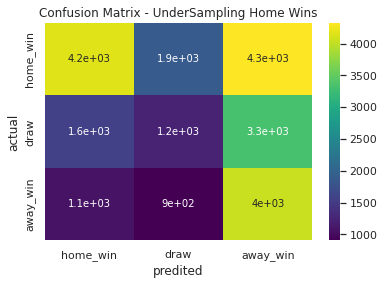

In [30]:
plot_confusion_matrix(MinMaxLogisticRegressionResample, title='Confusion Matrix - UnderSampling Home Wins')

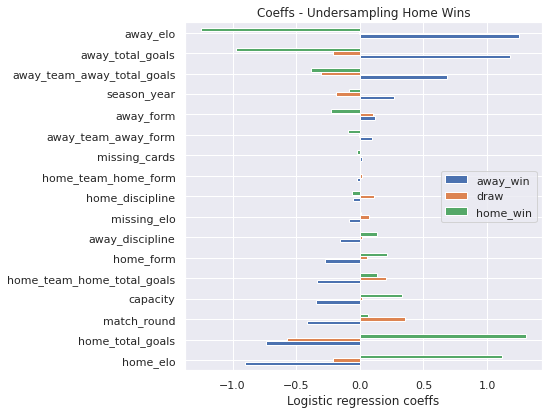

In [31]:
plot_logistic_regression_coeffs(MinMaxLogisticRegression, cols = X_train_resample.columns, title='Coeffs - Undersampling Home Wins')

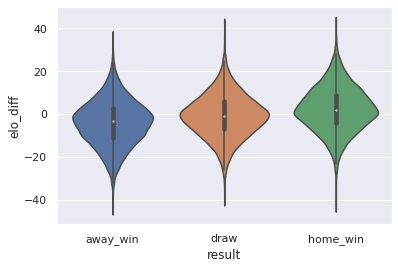

In [32]:
sns.violinplot(data=transformed_df.assign(elo_diff=transformed_df.home_elo-transformed_df.away_elo)[~transformed_df.missing_elo], y='elo_diff', x='result');

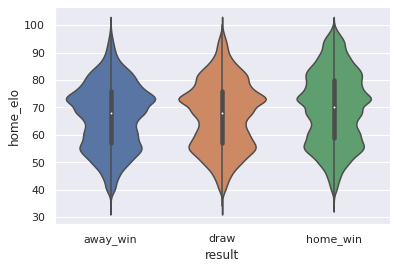

In [33]:
sns.violinplot(data=transformed_df, y='home_elo', x='result');

## Random Forest Classifier and Hyper-parameter tuning (Bayesian Optimisation)

In [34]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
accuracy_score(y_valid, rf_clf.predict(X_valid))

0.47003154574132494

In [35]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_diff_features, y_train)
accuracy_score(y_valid, rf_clf.predict(X_valid_diff_features))

0.46772115341893633

In [38]:
rstate = np.random.default_rng(42)

params={'n_estimators': hp.choice('n_estimators', np.arange(100, 501, dtype=int)),
           'max_depth': hp.choice('max_depth', np.arange(5, 21, dtype=int)),
           'min_samples_leaf': hp.choice('min_samples_leaf', np.arange(1, 11, dtype=int)),
           'min_samples_split': hp.choice('min_samples_split', np.arange(2, 21, dtype=int))}

def hyperparameter_tuning(params):

    clf = RandomForestClassifier(**params, n_jobs=-1, random_state=42)
    clf.fit(X_train, y_train)
    acc = accuracy_score(y_valid, clf.predict(X_valid))
    return {'loss': -acc, 'status': STATUS_OK}

# Initialize trials object
trials = Trials()

best = fmin(
    fn=hyperparameter_tuning,
    space = params,
    algo=tpe.suggest,
    max_evals=24,
    trials=trials,
    rstate=rstate
)

# print("Best: {}".format(best))
best

100%|██████████| 24/24 [06:54<00:00, 17.25s/trial, best loss: -0.4914915359665882] 


{'max_depth': 7,
 'min_samples_leaf': 8,
 'min_samples_split': 13,
 'n_estimators': 27}

In [39]:
rf_clf = RandomForestClassifier(**best, random_state=42)
rf_clf.fit(X_train, y_train)
accuracy_score(y_valid, rf_clf.predict(X_valid))

0.4869151819433954

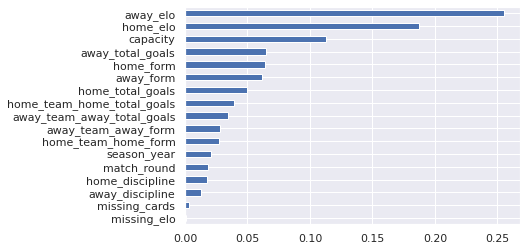

In [41]:
feature_importances = pd.Series(rf_clf.feature_importances_, index=X_train.columns)
feature_importances.sort_values().plot.barh();

In [42]:
rstate = np.random.default_rng(42)

params={'n_estimators': hp.choice('n_estimators', np.arange(100, 501, dtype=int)),
           'max_depth': hp.choice('max_depth', np.arange(5, 21, dtype=int)),
           'min_samples_leaf': hp.choice('min_samples_leaf', np.arange(1, 11, dtype=int)),
           'min_samples_split': hp.choice('min_samples_split', np.arange(2, 21, dtype=int))}

def hyperparameter_tuning(params):

    clf = RandomForestClassifier(**params, n_jobs=-1, random_state=42)
    clf.fit(X_train_diff_features, y_train)
    acc = accuracy_score(y_valid, clf.predict(X_valid_diff_features))
    return {'loss': -acc, 'status': STATUS_OK}

# Initialize trials object
trials = Trials()

best = fmin(
    fn=hyperparameter_tuning,
    space = params,
    algo=tpe.suggest,
    max_evals=24,
    trials=trials,
    rstate=rstate
)

# print("Best: {}".format(best))
best

100%|██████████| 24/24 [06:23<00:00, 15.99s/trial, best loss: -0.4922468565335229] 


{'max_depth': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 328}

In [43]:
rf_clf = RandomForestClassifier(**best, random_state=42)
rf_clf.fit(X_train_diff_features, y_train)
accuracy_score(y_valid, rf_clf.predict(X_valid_diff_features))

0.4877149331319145

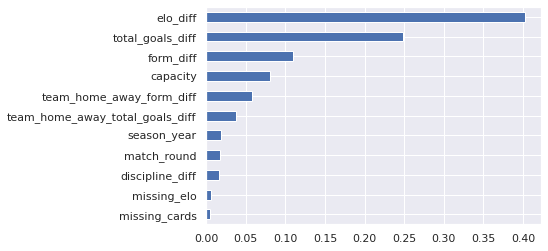

In [44]:
feature_importances = pd.Series(rf_clf.feature_importances_, index=X_train_diff_features.columns)
feature_importances.sort_values().plot.barh();

## Leave one feature out - feature selection

In [45]:
# clf = lgb.LGBMClassifier()
# clf.fit(X_train, y_train)
rstate = np.random.default_rng(42)

params={'num_leaves': hp.choice('num_leaves', np.arange(10, 20, dtype=int)),
           'max_depth': hp.choice('max_depth', np.arange(2, 8, dtype=int))}
        #    'min_data_in_leaf': hp.choice('min_data_in_leaf', np.arange(25, 100, dtype=int))}

def hyperparameter_tuning(params):

    clf = lgb.LGBMClassifier(**params, random_state=42)
    clf.fit(X_train, y_train)
    acc = accuracy_score(y_valid, clf.predict(X_valid))
    return {'loss': -acc, 'status': STATUS_OK}

# Initialize trials object
trials = Trials()

best = fmin(
    fn=hyperparameter_tuning,
    space = params,
    algo=tpe.suggest,
    max_evals=24,
    trials=trials,
    rstate=rstate
)

# print("Best: {}".format(best))
best

100%|██████████| 24/24 [00:54<00:00,  2.28s/trial, best loss: -0.4934020526947172]


{'max_depth': 1, 'num_leaves': 8}

In [46]:
X_merge_train = pd.concat([X_train, X_valid], axis=0)
y_merge_train = pd.concat([y_train, y_valid])

train_idx = np.arange(X_train.shape[0])
valid_idx = np.arange(X_train.shape[0], X_merge_train.shape[0])

In [47]:
params={'num_leaves': [10,12,14,15,16,18,20],
           'max_depth': [1,2,3,4,5,6,7]}
clf = lgb.LGBMClassifier(random_state=42)

grid = GridSearchCV(estimator=clf, param_grid=params, scoring='accuracy', cv=[(train_idx, valid_idx)], return_train_score=True)
grid.fit(X_merge_train, y_merge_train)

GridSearchCV(cv=[(array([    0,     1,     2, ..., 74620, 74621, 74622]),
                  array([74623, 74624, 74625, ..., 97127, 97128, 97129]))],
             estimator=LGBMClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7],
                         'num_leaves': [10, 12, 14, 15, 16, 18, 20]},
             return_train_score=True, scoring='accuracy')

In [48]:
grid.best_score_, grid.best_params_

(0.4942906651264051, {'max_depth': 4, 'num_leaves': 14})

In [49]:
# Training Score
grid.cv_results_['split0_train_score'][np.argmax(grid.cv_results_['split0_test_score'])]

0.49657612264315293

In [50]:
clf = lgb.LGBMClassifier(**grid.best_params_, random_state=42)
clf.fit(X_train, y_train)
base_acc = accuracy_score(y_valid, clf.predict(X_valid))
base_acc

0.4942906651264051

In [51]:
cols = X_train.columns.to_list()
acc_score = []
for col in cols:
    X_train_drop = X_train.drop(columns=col)
    
    clf = lgb.LGBMClassifier(**grid.best_params_, random_state=42)
    clf.fit(X_train_drop, y_train)
    
    lofo_acc = accuracy_score(y_valid, clf.predict(X_valid.drop(columns=col)))
    result = base_acc - lofo_acc
    acc_score.append(result)

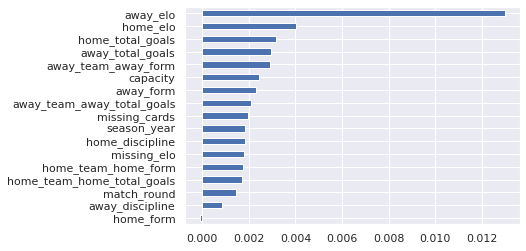

In [52]:
lofo_scores = pd.Series(index = cols, data = acc_score)
lofo_scores.sort_values().plot.barh();

In [53]:
lofo_scores['home_form']

-8.886124316875854e-05

## Permutation Importance

In [54]:
clf = lgb.LGBMClassifier(**grid.best_params_, random_state=42)
clf.fit(X_train, y_train)
perm = PermutationImportance(clf, scoring='accuracy', random_state=42).fit(X_valid, y_valid)

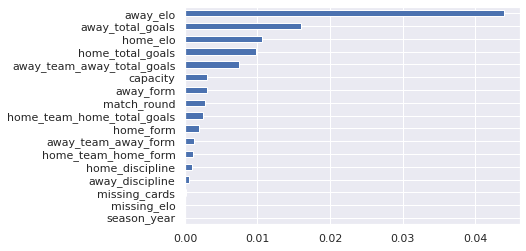

In [55]:
perm_importance = pd.Series(data = perm.feature_importances_, index = X_train.columns.to_list())
perm_importance.sort_values().plot.barh();

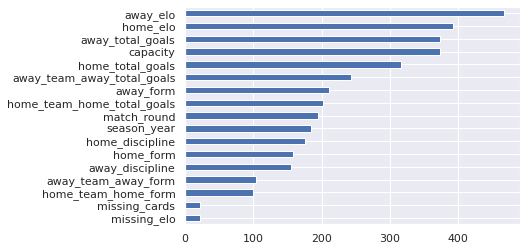

In [56]:
feature_importances = pd.Series(data = clf.feature_importances_, index=clf.feature_name_)
feature_importances.sort_values().plot.barh();

## Fitting with different subsets of the data

In [57]:
# valid_acc, train_acc, LGBMNoMissingElo = train_model_return_train_validation_accuracy(None, lgb.LGBMClassifier(**grid.best_params_, random_state=42), X_train_drop_missing_elo, y_train_drop_missing_elo, X_valid_drop_missing_elo, y_valid)
# valid_acc, train_acc

clf = lgb.LGBMClassifier(**grid.best_params_, random_state=42)
clf.fit(X_train_drop_missing_elo, y_train_drop_missing_elo)
accuracy_score(y_valid, clf.predict(X_valid_drop_missing_elo)), accuracy_score(y_train_drop_missing_elo, clf.predict(X_train_drop_missing_elo))

(0.49162482783134137, 0.50026855731013)

In [58]:
columns_to_drop = ['missing_elo', 'season_year', 'missing_cards', 'home_discipline', 'away_discipline', 'home_team_home_form', 'away_team_away_form']

clf = lgb.LGBMClassifier(**grid.best_params_, random_state=42)
clf.fit(X_train.drop(columns=columns_to_drop), y_train)
accuracy_score(y_valid, clf.predict(X_valid.drop(columns=columns_to_drop))), accuracy_score(y_train, clf.predict(X_train.drop(columns=columns_to_drop)))

(0.4921135646687697, 0.49385578172949357)

In [59]:
params={'num_leaves': [10,12,14,15,16,18,20],
           'max_depth': [1,2,3,4,5,6,7]}
clf = lgb.LGBMClassifier(random_state=42)

grid = GridSearchCV(estimator=clf, param_grid=params, scoring='accuracy', cv=[(train_idx, valid_idx)], return_train_score=True)
grid.fit(X_merge_train.drop(columns = columns_to_drop), y_merge_train)

GridSearchCV(cv=[(array([    0,     1,     2, ..., 74620, 74621, 74622]),
                  array([74623, 74624, 74625, ..., 97127, 97128, 97129]))],
             estimator=LGBMClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7],
                         'num_leaves': [10, 12, 14, 15, 16, 18, 20]},
             return_train_score=True, scoring='accuracy')

In [60]:
grid.best_score_, grid.best_params_

(0.4921135646687697, {'max_depth': 4, 'num_leaves': 14})

In [61]:
params={'num_leaves': [10,12,14,15,16,18,20],
           'max_depth': [1,2,3,4,5,6,7]}
clf = lgb.LGBMClassifier(random_state=42)

grid = GridSearchCV(estimator=clf, param_grid=params, scoring='accuracy', cv=[(train_idx, valid_idx)], return_train_score=True)
grid.fit(X_merge_train.drop(columns = 'home_form'), y_merge_train)

grid.best_score_, grid.best_params_

(0.4943795263695739, {'max_depth': 4, 'num_leaves': 14})

In [62]:
best_acc = grid.best_score_

> **Best Score so far!!**

In [63]:
years_to_drop = np.arange(1990,2001)
acc_score = []
for year in years_to_drop:
    X_train_drop = X_train.query("season_year > @year").drop(columns='home_form')
    y_train_temp = pd.concat([X_train.season_year, y_train], axis=1).query("season_year > @year")
    y_train_years_dropped = y_train_temp.result
    
    clf = lgb.LGBMClassifier(**grid.best_params_, random_state=42)
    clf.fit(X_train_drop, y_train_years_dropped)
    
    lofo_acc = accuracy_score(y_valid, clf.predict(X_valid.drop(columns='home_form')))
    result = base_acc - lofo_acc
    acc_score.append(result)

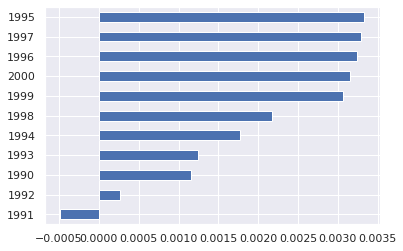

In [64]:
lofo_scores_years_to_drop = pd.Series(index = years_to_drop, data = acc_score)
lofo_scores_years_to_drop.sort_values().plot.barh();

In [65]:
X_train_years_dropped = X_train.query("season_year > 1991").drop(columns='home_form')
y_train_temp = pd.concat([X_train.season_year, y_train], axis=1).query("season_year > 1991")
y_train_years_dropped = y_train_temp.result

clf = lgb.LGBMClassifier(**grid.best_params_, random_state=42)
clf.fit(X_train_years_dropped, y_train_years_dropped)
accuracy_score(y_valid, clf.predict(X_valid.drop(columns='home_form'))), accuracy_score(y_train_years_dropped, clf.predict(X_train_years_dropped))

(0.49477940196383347, 0.49691079074867023)

> **Another small improvement**

## Train classifier using full train set and evaluate on test set

In [66]:
X_train_final = train[features_cols]
y_train_final = train.result

X_test = test[features_cols]
y_test = test.result

X_train_final_years_dropped = X_train_final.query("season_year > 1991").drop(columns='home_form')
y_train_final_temp = pd.concat([X_train_final.season_year, y_train_final], axis=1).query("season_year > 1991")
y_train_final_years_dropped = y_train_final_temp.result

clf = lgb.LGBMClassifier(**grid.best_params_, random_state=42)
clf.fit(X_train_final_years_dropped, y_train_final_years_dropped)

accuracy_score(y_test, clf.predict(X_test.drop(columns='home_form')))

0.4846012005178705

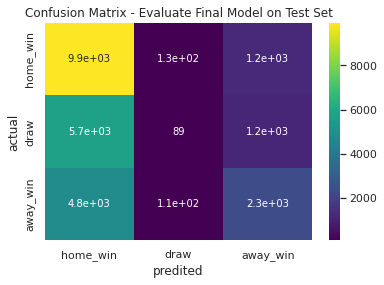

In [67]:
labels = ['home_win', 'draw', 'away_win']
confusion_matrix_output = confusion_matrix(y_test, clf.predict(X_test.drop(columns='home_form')), labels=labels)

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix_output, annot=True, cmap='viridis', 
            xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('predited')
ax.set_ylabel('actual')
ax.set_title('Confusion Matrix - Evaluate Final Model on Test Set');